# A neuromuscular model of human locomotion combines spinal reflex circuits with voluntary movements 
### (https://www.nature.com/articles/s41598-022-11102-1)

## Architecture

<img src="../images/flexible_walker.png" alt="Flexible Walker Pipeline" width="500">

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Supraspinal Layer
### Volition

In [2]:
def volition(alpha, h_o, c):
    """
    Compute the desired joint angles for the swing limb.

    Args:
        alpha: Array of scaling factors for each joint [list or np.array].
        h_o: High-level goal (e.g., step height or leg extension) [float].
        c: Array of offsets for each joint [list or np.array].

    Returns:
        theta_desired: Array of desired joint angles [list or np.array].
    """
    theta_desired = alpha * h_o + c
    return theta_desired

In [3]:
# Example parameters
alpha = np.array([1.0, 0.5, 0.2])  # Scaling factors for hip, knee, ankle
h_o = 0.3  # High-level goal (e.g., step height)
c = np.array([0.1, -0.2, 0.05])  # Offsets for hip, knee, ankle

theta_desired = volition(alpha, h_o, c)
print("Desired Joint Angles:", theta_desired)

Desired Joint Angles: [ 0.4  -0.05  0.11]


### Balance Control

In [4]:
def balance_control(phi_0, c_d, c_v, d, v, phi_trunk, t, delta_t):
    """
    Compute the desired thigh orientation and target hip joint angles for balance control.

    Args:
        phi_0: Constant offset for desired thigh orientation [float].
        c_d: Feedback gain for displacement [float].
        c_v: Feedback gain for velocity [float].
        d: Horizontal displacement from CoP to trunk center [function of time].
        v: Rate of change of displacement [function of time].
        phi_trunk: Trunk orientation [function of time].
        t: Current time [float].
        delta_t: Time delay for feedback [float].

    Returns:
        phi_thigh_desired: Desired thigh orientation [float].
        theta_hip_desired: Target hip joint angle [float].
    """
    # Time-delayed feedback
    d_delayed = d(t - delta_t)
    v_delayed = v(t - delta_t)
    phi_trunk_delayed = phi_trunk(t - delta_t)

    # Desired thigh orientation
    phi_thigh_desired = phi_0 + c_d * d_delayed + c_v * v_delayed

    # Target hip joint angle
    theta_hip_desired = phi_thigh_desired - phi_trunk_delayed

    return phi_thigh_desired, theta_hip_desired

In [ ]:
# Example parameters
phi_0 = 0.1  # Constant offset
c_d = 0.5  # Displacement feedback gain
c_v = 0.3  # Velocity feedback gain
t = 1.0  # Current time
delta_t = 0.1  # Time delay [s]

# Example state feedback functions
def d(t): return 0.2 * np.sin(t)  # Example displacement
def v(t): return 0.2 * np.cos(t)  # Example velocity
def phi_trunk(t): return 0.05 * np.sin(t)  # Example trunk orientation

phi_thigh_desired, theta_hip_desired = balance_control(phi_0, c_d, c_v, d, v, phi_trunk, t, delta_t)

print(f"Desired Thigh Orientation: {phi_thigh_desired:.3f}")
print(f"Target Hip Joint Angle: {theta_hip_desired:.3f}")

Desired Thigh Orientation: 0.216
Target Hip Joint Angle: 0.176


### Motor Plan: Minimal Jerks

In [6]:
def compute_minimum_jerk_coefficients(X_0, X_tgt, T):
    """
    Compute the coefficients of the minimum jerk trajectory.

    Args:
        X_0: Initial state [theta_0, theta_dot_0, theta_ddot_0].
        X_tgt: Target state [theta_tgt, theta_dot_tgt, theta_ddot_tgt].
        T: Movement duration [s].

    Returns:
        a: Coefficients of the 5th-order polynomial [list of floats].
    """
    theta_0, theta_dot_0, theta_ddot_0 = X_0
    theta_tgt, theta_dot_tgt, theta_ddot_tgt = X_tgt

    # Solve for coefficients using boundary conditions
    T2 = T ** 2
    T3 = T ** 3
    T4 = T ** 4
    T5 = T ** 5

    a0 = theta_0
    a1 = theta_dot_0
    a2 = theta_ddot_0 / 2
    a3 = (20 * (theta_tgt - theta_0) - (8 * theta_dot_tgt + 12 * theta_dot_0) * T -
          (3 * theta_ddot_0 - theta_ddot_tgt) * T2) / (2 * T3)
    a4 = (30 * (theta_0 - theta_tgt) + (14 * theta_dot_tgt + 16 * theta_dot_0) * T +
          (3 * theta_ddot_0 - 2 * theta_ddot_tgt) * T2) / (2 * T4)
    a5 = (12 * (theta_tgt - theta_0) - (6 * theta_dot_tgt + 6 * theta_dot_0) * T -
          (theta_ddot_0 - theta_ddot_tgt) * T2) / (2 * T5)

    return [a0, a1, a2, a3, a4, a5]


def compute_minimum_jerk_trajectory(a, t):
    """
    Compute the desired state (position, velocity, acceleration) at time t.

    Args:
        a: Coefficients of the 5th-order polynomial [list of floats].
        t: Current time [s].

    Returns:
        x: Desired position [float].
        x_dot: Desired velocity [float].
        x_ddot: Desired acceleration [float].
    """
    x = a[0] + a[1] * t + a[2] * t**2 + a[3] * t**3 + a[4] * t**4 + a[5] * t**5
    x_dot = a[1] + 2 * a[2] * t + 3 * a[3] * t**2 + 4 * a[4] * t**3 + 5 * a[5] * t**4
    x_ddot = 2 * a[2] + 6 * a[3] * t + 12 * a[4] * t**2 + 20 * a[5] * t**3
    return x, x_dot, x_ddot


def movement_planning(X_t, X_tgt, T, t):
    """
    Plan the movement trajectory in real-time.

    Args:
        X_t: Current state [theta, theta_dot, theta_ddot].
        X_tgt: Target state [theta_tgt, theta_dot_tgt, theta_ddot_tgt].
        T: Total movement duration [s].
        t: Current time [s].

    Returns:
        x_desired: Desired position [float].
        x_dot_desired: Desired velocity [float].
        x_ddot_desired: Desired acceleration [float].
    """
    remaining_time = T - t
    if remaining_time < 0.03:  # Stop updating if time is too short
        return X_tgt

    # Compute coefficients for the remaining time
    a = compute_minimum_jerk_coefficients(X_t, X_tgt, remaining_time)

    # Compute the desired state at the current time
    x_desired, x_dot_desired, x_ddot_desired = compute_minimum_jerk_trajectory(a, t=0)  # t=0 for the new trajectory
    return x_desired, x_dot_desired, x_ddot_desired

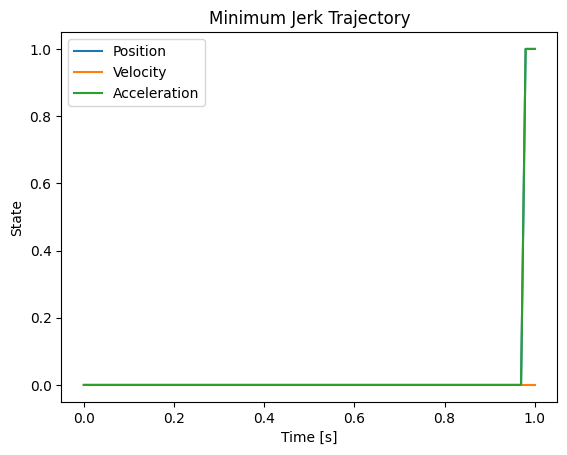

In [9]:
# Example parameters
X_0 = [0.0, 0.0, 0.0]  # Initial state: [theta, theta_dot, theta_ddot]
X_tgt = [1.0, 0.0, 1.0]  # Target state: [theta_tgt, theta_dot_tgt, theta_ddot_tgt]
T = 1.0  # Total movement duration [s]

t_values = np.linspace(0, T, 100)
trajectory = []

for t in t_values:
    x, x_dot, x_ddot = movement_planning(X_0, X_tgt, T, t)
    trajectory.append((x, x_dot, x_ddot))

trajectory = np.array(trajectory)

plt.figure()
plt.plot(t_values, trajectory[:, 0], label="Position")
plt.plot(t_values, trajectory[:, 1], label="Velocity")
plt.plot(t_values, trajectory[:, 2], label="Acceleration")
plt.xlabel("Time [s]")
plt.ylabel("State")
plt.title("Minimum Jerk Trajectory")
plt.legend()
plt.show()

## Internal Model

### Inverse Dynamics

In [10]:
def compute_joint_torques(theta, theta_dot, theta_ddot, M, C, G):
    """
    Compute the joint torques using the biomechanical equations of motion.

    Args:
        theta: Time-delayed joint angles [array].
        theta_dot: Time-delayed joint velocities [array].
        theta_ddot: Planned joint accelerations for the full model [array].
        M: Mass/inertia matrix [function of theta].
        C: Coriolis/centrifugal forces [function of theta, theta_dot].
        G: Gravitational forces [function of theta].

    Returns:
        tau_full: Full joint torque vector [array].
    """
    tau_full = M(theta) @ theta_ddot + C(theta, theta_dot) + G(theta)
    return tau_full


def augment_accelerations(theta_swing_ddot, n_trunk=6, n_swing=4, n_stance=4):
    """
    Augment the planned swing leg accelerations with zeros for the trunk and stance leg.

    Args:
        theta_swing_ddot: Planned joint accelerations for the swing leg [array].
        n_trunk: Number of DoFs for the trunk [int].
        n_swing: Number of DoFs for the swing leg [int].
        n_stance: Number of DoFs for the stance leg [int].

    Returns:
        theta_full_ddot: Full joint acceleration vector [array].
    """
    theta_full_ddot = np.zeros(n_trunk + n_swing + n_stance)
    theta_full_ddot[n_trunk:n_trunk + n_swing] = theta_swing_ddot
    return theta_full_ddot


def extract_swing_torques(tau_full, n_trunk=6, n_swing=4):
    """
    Extract the swing leg torques from the full joint torque vector.

    Args:
        tau_full: Full joint torque vector [array].
        n_trunk: Number of DoFs for the trunk [int].
        n_swing: Number of DoFs for the swing leg [int].

    Returns:
        tau_swing: Swing leg joint torques [array].
    """
    tau_swing = tau_full[n_trunk:n_trunk + n_swing]
    return tau_swing

In [12]:
def M(theta):
    # Example mass/inertia matrix (diagonal for simplicity)
    return np.diag([1.0] * len(theta))

def C(theta, theta_dot):
    # Example Coriolis/centrifugal forces (zero for simplicity)
    return np.zeros(len(theta))

def G(theta):
    # Example gravitational forces (constant for simplicity)
    return np.array([9.81] * len(theta))

theta = np.array([0.1] * 14)  # Time-delayed joint angles
theta_dot = np.array([0.0] * 14)  # Time-delayed joint velocities
theta_swing_ddot = np.array([1.0, 0.5, -0.5, 0.2])  # Planned swing leg accelerations

theta_full_ddot = augment_accelerations(theta_swing_ddot)
tau_full = compute_joint_torques(theta, theta_dot, theta_full_ddot, M, C, G)
tau_swing = extract_swing_torques(tau_full)

print("Full Joint Torques:", tau_full)
print("Swing Leg Torques:", tau_swing)

Full Joint Torques: [ 9.81  9.81  9.81  9.81  9.81  9.81 10.81 10.31  9.31 10.01  9.81  9.81
  9.81  9.81]
Swing Leg Torques: [10.81 10.31  9.31 10.01]


### Force inversion

In [13]:
def muscle_force_inversion(C, tau, max_iterations=7):
    """
    Compute muscle forces that generate the desired joint torques using iterative approximation.

    Args:
        C: Moment arm matrix [2D array].
        tau: Desired joint torques [1D array].
        max_iterations: Number of iterations for the approximation [int].

    Returns:
        F: Muscle force vector [1D array].
    """
    # Compute the pseudo-inverse of the moment arm matrix
    C_pseudo_inv = np.linalg.pinv(C)

    # Initialize variables
    F_total = np.zeros(C.shape[1])  # Total positive forces
    tau_negative = tau  # Initialize with the desired torques

    for i in range(max_iterations):
        # Compute muscle forces for the current torques
        F = C_pseudo_inv @ tau_negative

        # Separate positive and negative forces
        F_positive = np.maximum(F, 0)  # Keep only positive forces
        F_negative = np.minimum(F, 0)  # Keep only negative forces

        # Add positive forces to the total
        F_total += F_positive

        # Compute the torques produced by the negative forces
        tau_negative = C @ F_negative

    return F_total

In [15]:
# Example moment arm matrix (4 muscles, 2 joints)
C = np.array([[0.05, -0.02, 0.03, 0.0],
              [0.0, 0.04, -0.01, 0.02]])

# Example desired joint torques
tau = np.array([10.0, -5.0])  # Desired torques for 2 joints

F = muscle_force_inversion(C, tau)
print("Muscle Forces:", F)

Muscle Forces: [114.47562777   0.         139.30284077   0.        ]


### Muscle Inversion

In [16]:
def compute_neural_stimulation(F_desired, F_max, L, V, L_opt, w_L, c_v):
    """
    Compute the neural stimulation needed to generate the desired muscle force.

    Args:
        F_desired: Desired muscle force [array].
        F_max: Maximum isometric force of the muscle [array].
        L: Current muscle lengths [array].
        V: Current muscle velocities [array].
        L_opt: Optimal muscle lengths [array].
        w_L: Width of the force–length Gaussian [float].
        c_v: Velocity scaling factor for force–velocity relationship [float].

    Returns:
        S: Neural stimulation [array].
    """
    # Force–length relationship
    f_l = np.exp(-((L - L_opt) / w_L) ** 2)

    # Force–velocity relationship
    f_v = 1 / (1 + c_v * V)

    # Compute neural stimulation
    S = F_desired / (F_max * f_l * f_v)
    return S

In [18]:
# Example parameters
F_desired = np.array([100, 200, 150])  # Desired muscle forces [N]
F_max = np.array([300, 400, 350])  # Maximum isometric forces [N]
L = np.array([1.0, 1.1, 0.9])  # Current muscle lengths [norm]
V = np.array([0.1, -0.2, 0.05])  # Current muscle velocities [norm/s]
L_opt = np.array([1.0, 1.0, 1.0])  # Optimal muscle lengths [norm]
w_L = 0.25  # Width of the force–length Gaussian
c_v = 2.0  # Velocity scaling factor

S = compute_neural_stimulation(F_desired, F_max, L, V, L_opt, w_L, c_v)
print("Neural Stimulation:", S)

Neural Stimulation: [0.4        0.35205326 0.55322655]


### Stretch-Reflex Inversion

In [19]:
def compute_descending_command(S_desired, h, K_l, l_CE):
    """
    Compute the descending motor command for spinal stretch reflex modulation.

    Args:
        S_desired: Desired muscle activation [array].
        h: Bias term for stretch reflex reference point [array].
        K_l: Gain of the stretch reflex for muscle length [array].
        l_CE: Current contractile element length of the muscle [array].

    Returns:
        u: Descending motor command [array].
    """
    u = (S_desired + h) / K_l - l_CE
    return u

In [20]:
# Example parameters
S_desired = np.array([0.5, 0.7, 0.6])  # Desired muscle activation
h = np.array([0.1, 0.2, 0.15])  # Bias term
K_l = np.array([1.0, 1.2, 1.1])  # Stretch reflex gain
l_CE = np.array([0.9, 1.0, 0.95])  # Current contractile element length

u = compute_descending_command(S_desired, h, K_l, l_CE)
print("Descending Motor Command:", u)

Descending Motor Command: [-0.3        -0.25       -0.26818182]
